In [1]:
import pandas as pd
import numpy as np

from clustering_functions import *
from impute_transform import ImputeTransform
from fancyimpute import MatrixFactorization

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


# Unsupervised Learning in ADHD

## Introduction

## Overview of Methods

Participants with null values have values imputed by Matrix Factorization.
The full dataset is then split by TMCQ or Neuropsych columns.

## Overview of Results (?)

---

# TMCQ Cluster Analysis

## Prepare Data

In [3]:
%%capture
data = pd.read_csv('data/full_data.csv')
#small_data = data.sample(n=200)
TMCQ_all, TMCQ_adhd, TMCQ_control = prep_data(data, dataset='TMCQ')

In [28]:
print_ns(TMCQ_all, TMCQ_adhd, TMCQ_control)

Ns for each group
-----------------
All:      901
ADHD:     574
Control:  327


## Choose K for each group

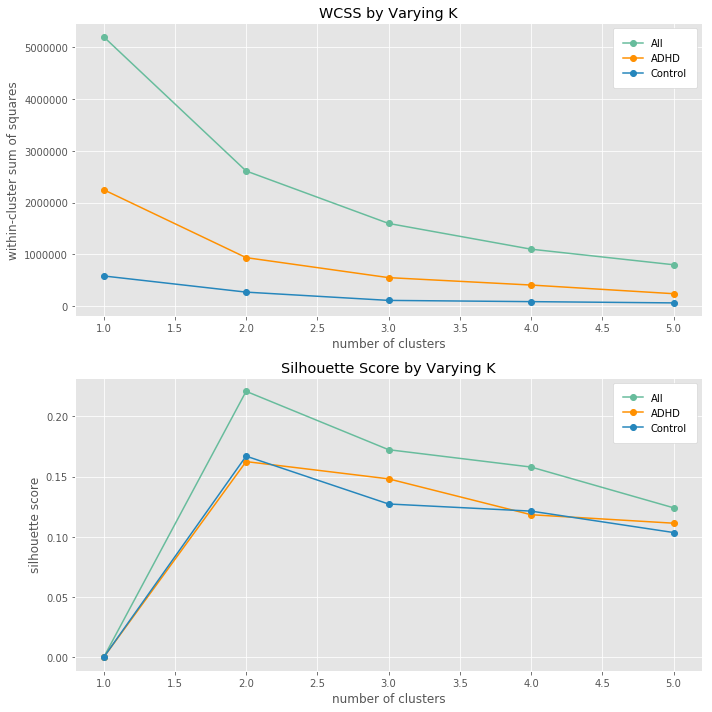

In [29]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
km = KMeans(n_jobs=-1)
wcss_and_silhouette(TMCQ_all, km, axs, 'All', '#67bc9c')
wcss_and_silhouette(TMCQ_adhd, km, axs, 'ADHD', '#ff9000')
wcss_and_silhouette(TMCQ_control, km, axs, 'Control', '#2586bc')
plt.tight_layout()

2 seems to be the best number of clusters for all groups.

## Group = All, K = 2

What kind of insights can we gain from the KMeans Cluster Analysis on the TMCQ dataset with all subjects?

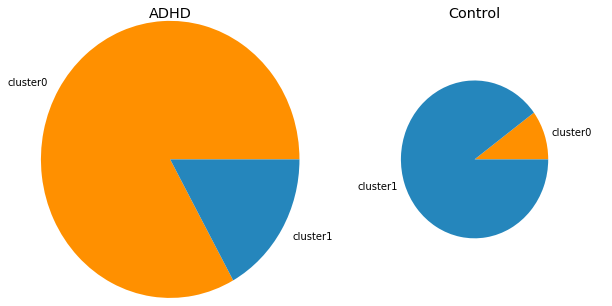

In [31]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
build_piechart(TMCQ_all, data, km, 'DX', axs)

Here we can see that Cluster 0 roughly corresponds to Control, and Cluster 1 roughly corresponds to ADHD.

Radius of the pie chart is: (N of the diagnosis group / total N) * 2

Below is proportions of clusters per DX group for DXSUB.

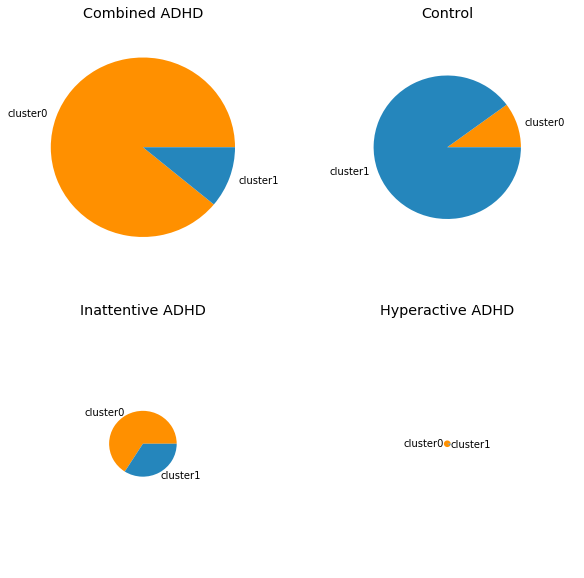

In [32]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
build_piechart(TMCQ_all, data, km, 'DXSUB', axs.flatten(),
               title_dict = {1.0: 'Control', 3.0:
                             'Inattentive ADHD', 4.0: 'Hyperactive ADHD', 5.0: 'Combined ADHD'})

This is a little less informative (particularly for Inattentive and Hyperactive ADHD because of their low Ns). However we see the same pattern of Cluster 1 corresponding to ADHD subtypes.

## Group = ADHD, Control, K = 2

We will now examine the TMCQ scores. We split the TMCQ dataset into ADHD and Control groups. On each group, we run KMeans(n_clusters=2). We then compare mean TMCQ scores in each cluster between the groups.

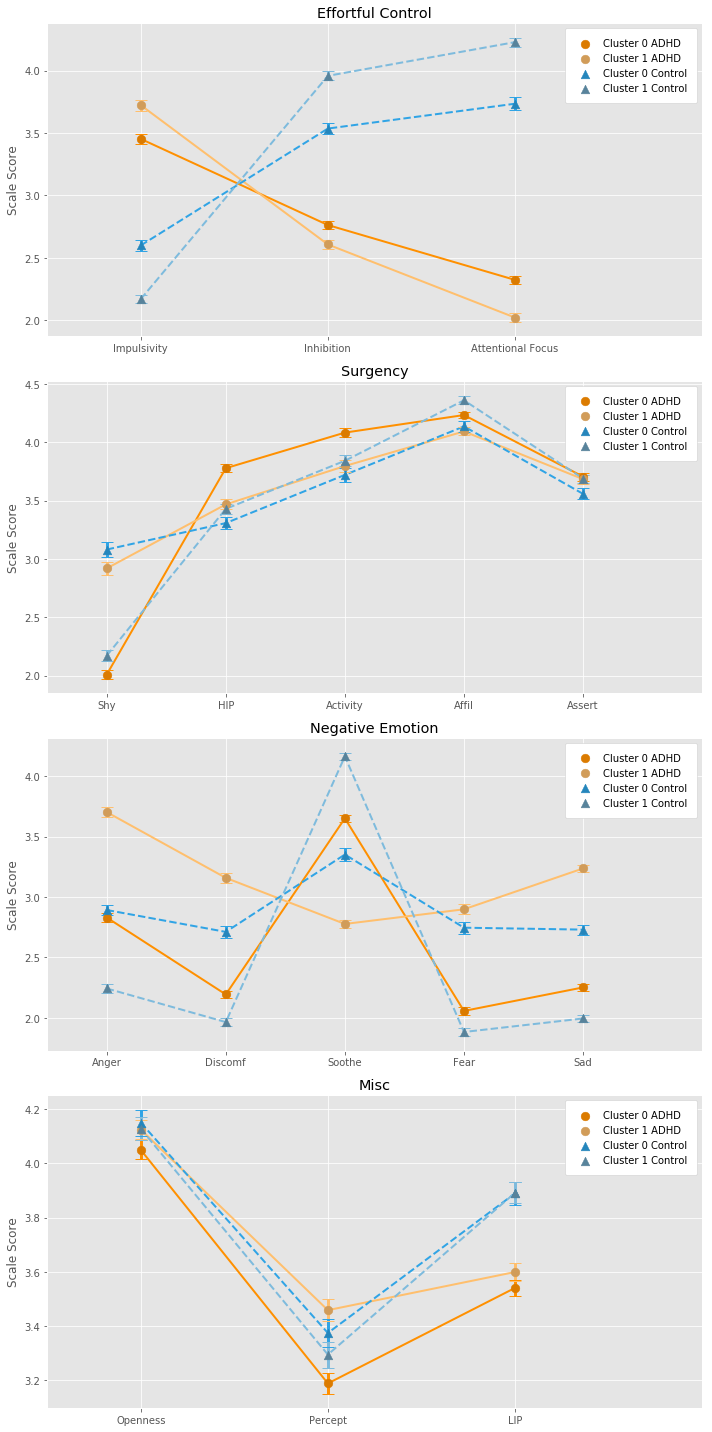

In [13]:
fig, axs = plt.subplots(4,1,figsize=(10,20))

km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
run_ADHD_Control_k2(TMCQ_adhd, TMCQ_control, km, axs, dataset='TMCQ')

plt.tight_layout()

---

# Neuropsych Cluster Analysis

## Prepare Data

In [14]:
%%capture
data = pd.read_csv('data/full_data.csv')
#small_data = data.sample(n=200)
neuro_all, neuro_adhd, neuro_control = prep_data(data, dataset='neuro')

In [38]:
print_ns(neuro_all, neuro_adhd, neuro_control)

Ns for each group
-----------------
All:      901
ADHD:     574
Control:  327


## Choose K for each group

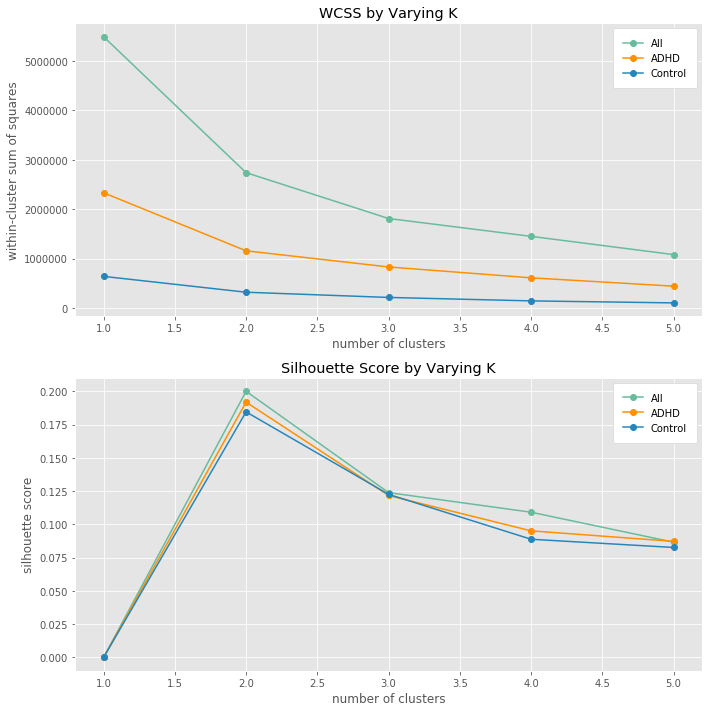

In [40]:
fig, axs = plt.subplots(2,1,figsize=(10,10))

scaler = StandardScaler()
kmeans = KMeans(n_jobs=-1, random_state=56)
steps = [('standard_scaler', scaler),
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

wcss_and_silhouette(neuro_all, pipeline, axs, 'All', '#67bc9c', standard_scale=True)
wcss_and_silhouette(neuro_adhd, pipeline, axs, 'ADHD', '#ff9000', standard_scale=True)
wcss_and_silhouette(neuro_control, pipeline, axs, 'Control', '#2586bc', standard_scale=True)

plt.tight_layout()

Again, 2 seems to be the best number of clusters for all groups.

## Group = All, K = 2

What kind of insights can we gain from the KMeans Cluster Analysis on the neuro dataset with all subjects?

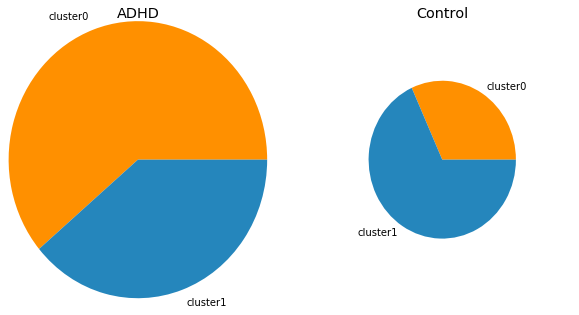

In [41]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

scaler = StandardScaler()
kmeans = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
steps = [('standard_scaler', scaler),
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

build_piechart(neuro_all, data, pipeline, 'DX', axs)

Here we can see that Cluster 0 roughly corresponds to Control, and Cluster 1 roughly corresponds to ADHD. The deliniation is not as good as in the TMCQ dataset.

Radius of the pie chart is: (N of the diagnosis group / total N) * 2

Below is proportions of clusters per DX group for DXSUB.

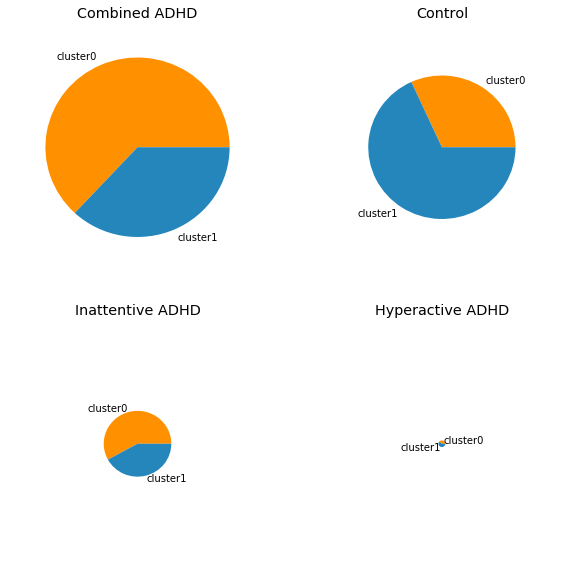

In [42]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
build_piechart(neuro_all, data, pipeline, 'DXSUB', axs.flatten(),
               title_dict = {1.0: 'Control', 3.0: 'Inattentive ADHD', 4.0: 'Hyperactive ADHD', 5.0: 'Combined ADHD'})

This is a little less informative (particularly for Inattentive and Hyperactive ADHD because of their low Ns). However we see the same pattern of Cluster 1 corresponding to ADHD subtypes.

## Group = ADHD, Control, K = 2

We will now examine the neuro scores. We normalize the whole dataset, and then split the neuro dataset into ADHD and Control groups. On each group, we run KMeans(n_clusters=2). We then compare mean neuro scores in each cluster between the groups.

In [44]:
%%capture
data = pd.read_csv('data/full_data.csv')
neuro_all, neuro_adhd, neuro_control = prep_data(data, dataset='neuro', scale='before')

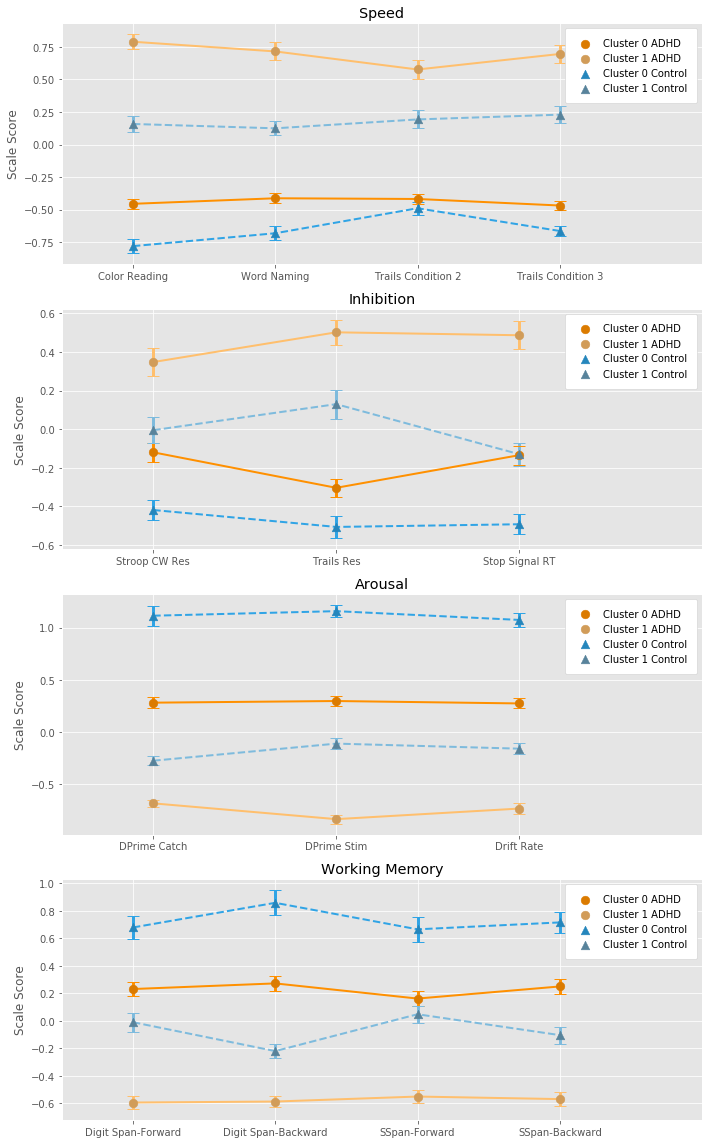

In [45]:
fig, axs = plt.subplots(4,1,figsize=(10,16))

km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
run_ADHD_Control_k2(neuro_adhd, neuro_control, km, axs, dataset='neuro')

plt.tight_layout()

Statistical tests go here

Neuro Cluster 1 ADHD - Poorer cognitive ability  
Neuro Cluster 1 Control - Poorer cognitive ability (still better than ADHD though)  
Neuro Cluster 0 ADHD - Higher cognitive  
Neuro Cluster 0 Control - Higher cognitive  

TMCQ Cluster 1 ADHD - Poorer effortful control, high shyness, higher negative emotion

---

# Bringing It Back Together

Is there any connection between the clusters seen in TMCQ scores, and clusters seen in neuropsych data? How about with DX or DXSUB?

To examine this, we look at confusion matrices for ADHD and control. The numbers returned are percentages.

In [24]:
%%capture
data = pd.read_csv('data/full_data.csv')
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
cluster_data = combine_datasets(data, km)

In [25]:
cluster_data

,STOP_SSRTAVE_Y1,DPRIME1_Y1,DPRIME2_Y1,SSBK_NUMCOMPLETE_Y1,SSFD_NUMCOMPLETE_Y1,V_Y1,Y1_CLWRD_COND1,Y1_CLWRD_COND2,Y1_DIGITS_BKWD_RS,Y1_DIGITS_FRWD_RS,...,Y1_P_TMCQ_PERCEPT,Y1_P_TMCQ_DISCOMF,Y1_P_TMCQ_OPENNESS,Y1_P_TMCQ_SURGENCY,Y1_P_TMCQ_EFFCONT,Y1_P_TMCQ_NEGAFFECT,DX,DXSUB,neuro_cluster,TMCQ_cluster
0,285.835000,0.237440,-0.125579,9.000000,9.000000,2.691400,36.000000,28.000000,7.000000,7.000000,...,2.777778,2.555556,4.222222,3.962290,4.062460,1.934841,1.0,1.0,0.0,0.0
1,370.050260,0.231609,0.946903,5.000000,7.000000,2.236731,67.000000,49.000000,7.000000,11.000000,...,4.800000,3.571429,4.600000,3.916667,3.253333,3.486667,3.0,3.0,1.0,1.0
2,244.476129,1.287838,2.603895,11.000000,7.000000,3.068819,45.000000,26.000000,7.000000,9.000000,...,3.800000,2.800000,4.777778,3.022222,3.950000,2.500397,1.0,1.0,1.0,1.0
3,322.485328,0.186778,1.313471,3.000000,7.000000,2.338033,53.000000,49.000000,6.000000,5.000000,...,2.758900,3.209730,4.319801,3.703487,3.064080,3.134623,3.0,5.0,1.0,1.0
4,302.715689,0.634811,1.626384,11.000000,7.000000,2.674616,54.000000,36.000000,6.000000,8.000000,...,4.000000,4.000000,4.857143,3.903704,3.473333,4.265952,3.0,5.0,0.0,1.0
5,366.911878,0.737105,1.543444,7.332209,7.929463,2.440827,56.281746,36.766797,5.727964,7.998882,...,3.927953,1.969092,4.452426,4.889692,3.237560,2.265383,3.0,5.0,1.0,0.0
6,347.166549,0.334698,1.433374,3.000000,7.000000,2.562898,47.000000,41.000000,6.000000,8.000000,...,3.570085,1.865071,4.016594,3.890513,3.452077,1.885650,1.0,1.0,0.0,0.0
7,305.414999,0.295528,1.405218,11.000000,7.000000,2.094178,57.000000,41.000000,3.000000,6.000000,...,3.688197,3.381358,4.568381,3.534122,2.916360,3.333103,3.0,5.0,1.0,1.0
8,295.801747,0.924537,2.534870,7.000000,9.000000,3.005036,49.000000,48.000000,7.000000,10.000000,...,3.233776,2.974418,4.176835,3.161513,3.702394,2.833116,1.0,1.0,0.0,1.0
9,293.042500,0.673008,1.239049,5.000000,7.000000,1.961300,49.000000,39.000000,6.000000,8.000000,...,3.714286,3.888889,4.250000,3.409524,3.166667,4.381349,1.0,1.0,0.0,1.0


In [ ]:
cluster1_adhd_

In [102]:
adhd_cluster, control_cluster = cluster_matrix(cluster_data)

In [103]:
adhd_cluster

,TMCQ Cluster 0,TMCQ Cluster 1
Neuro Cluster 0,0.297909,0.212544
Neuro Cluster 1,0.278746,0.210801


In [104]:
control_cluster

,TMCQ Cluster 0,TMCQ Cluster 1
Neuro Cluster 0,0.272171,0.146789
Neuro Cluster 1,0.296636,0.284404
